# Experiment 2 - Train a model using the VGG16 architecture

In this experiment we train a VGG16-based model to perform classification using the Flowers Recognition dataset from Kaggle (https://www.kaggle.com/alxmamaev/flowers-recognition).

We'll perform some steps to find the best performance as possible using this architecture and training the model from zero (without transferring weights from another model).

The results obtained here will be used later to compare with the results using a pre-trained model.

In [1]:
# %tensorflow_version 1.x
import os
import numpy as np
import tensorflow as tf
import random as rn
import keras
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from os import walk
from tqdm import *
from keras.utils import to_categorical
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import vgg16
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Reshape, Conv2D, Dropout, Activation, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import load_model

/home/ribani/virtual-envs/sibgrapi19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ribani/virtual-envs/sibgrapi19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ribani/virtual-envs/sibgrapi19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ribani/virtual-envs/sibgrapi19/lib

#### Set some variables to allow reproducibility

In [2]:
os.environ["PYTHONHASHSEED"] = "0"
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(42)
# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(42)

## Download the flowers dataset from kaggle

### Set kaggle username and key

In [ ]:
os.environ["KAGGLE_USERNAME"] = "{username}"
os.environ["KAGGLE_KEY"] = "{key}"

### Download using the Kaggle API

https://www.kaggle.com/docs/api

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip flowers-recognition.zip
!rm flowers-recognition.zip
!rm -f 'flowers/dandelion/flickr.py'
!rm -f 'flowers/dandelion/flickr.pyc'
!rm -f 'flowers/dandelion/run_me.py'
!rm -rf 'flowers/flowers'

## Organize data and split into train, validation and test

In [ ]:
dataset_path = 'flowers'
for (dirpath, dirnames, filenames) in walk(dataset_path):
    if (len(dirnames) > 0):
        folders_with_labels =  np.empty([len(dirnames), 3], dtype=object)
        i = 0
        for dir_name in sorted(dirnames, key=str.lower):
            folders_with_labels[i][0] = dir_name
            folders_with_labels[i][1] = i
            folders_with_labels[i][2] = []
            i += 1
print(folders_with_labels)

for path, label, imgs in folders_with_labels:
    for (dirpath, dirnames, filenames) in walk(os.path.join(dataset_path, path)):
        for file_name in filenames:
            imgs.append('{}/{},{}'.format(path, file_name, label))
            
print('-----------------------')
print("Total images per class...")
total = 0
for path, label, imgs in folders_with_labels:
    print(path, ":", len(imgs))
    total += len(imgs)
print('-----------------------')
print('Total of images:', total)

split_validation = 170
split_test = 170
train = []
val = []
test = []
for path, label, imgs in folders_with_labels:
    test.extend(imgs[0:split_test])
    val.extend(imgs[split_test:split_test+split_validation])
    train.extend(imgs[split_test+split_validation:len(imgs)])
    
print('-----------------------')
print('Total per set...')
print('x_train:', len(train))
print('x_test:', len(test))
print('x_val:', len(val))

from random import shuffle
shuffle(test)
shuffle(val)
shuffle(train)

print('-----------------------')
with open(os.path.join(dataset_path, 'test.txt'), 'w') as f:  
    f.writelines("%s\n" % item for item in test)
    print('File test.txt created.')
    
with open(os.path.join(dataset_path, 'val.txt'), 'w') as f:  
    f.writelines("%s\n" % item for item in val)
    print('File val.txt created.')
    
with open(os.path.join(dataset_path, 'train.txt'), 'w') as f:  
    f.writelines("%s\n" % item for item in train)
    print('File train.txt created.')

[['daisy' 0 list([])]
 ['dandelion' 1 list([])]
 ['rose' 2 list([])]
 ['sunflower' 3 list([])]
 ['tulip' 4 list([])]]
-----------------------
Total images per class...
daisy : 769
dandelion : 1052
rose : 784
sunflower : 734
tulip : 984
-----------------------
Total of images: 4323
-----------------------
Total per set...
x_train: 2623
x_test: 850
x_val: 850
-----------------------
File test.txt created.
File val.txt created.
File train.txt created.


### Set initial parameters, functions and generators

Set parameters for our model and training

In [3]:
dataset_path = 'data/flowers'
width = 224
height = 224
input_shape = (width, height, 3)
batch_size = 10
verbose = 1
classes_dict = {
    0: 'daisy',
    1: 'dandelion',
    2: 'rose',
    3: 'sunflower',
    4: 'tulip'
}

Here we define 3 functions:


*   read_training_file() : Read the paths to images and labels for the dataset using each file (train, validation and test).
*   preprocess_image() : Preprocess the images in batch, set the size, the type and put in the TF format (scale pixels between -1 and 1).
*   data_generator() : Returns a generator that reads the images in batch and call the preprocess function, to be used in the training process with the fit_generator function.



In [4]:
def read_training_file(path, separator=' '):
    images = []
    labels = []
    with open(path, 'r') as f:
        for i in tqdm(f.readlines()):
            img_name, cls = i.strip().split(separator)
            cls = int(cls)
            images.append(img_name)
            labels.append(cls)
    return images, labels

def preprocess_image(images, images_path, width, height):
    pp_images = []

    for image in images:
        img = cv2.imread(os.path.join(images_path, image))
        if img.shape[0] != 224 or img.shape[1] != 224:
            img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
        img = np.asarray(img, 'float32')
        img = preprocess_input(img, mode='tf')
        pp_images.append(img)

    return np.asarray(pp_images)

def data_generator(images, labels, batch_size, images_path, width, height):
    batch_start = 0
    while batch_start < len(images):
        batch_end = min(batch_start + batch_size, len(images))
        y_batch = labels[batch_start : batch_end]
        x_batch = preprocess_image(images[batch_start : batch_end],
                                   images_path,
                                   width,
                                   height)
        batch_start += batch_size
        if batch_start >= len(images):
            batch_start = 0
        yield (x_batch, y_batch)

Read the label files (train, val and test) and set two arrays:

1.   paths to images.
2.   labels as a binary class matrix, for use with categorical_crossentropy.



In [5]:
train_path = os.path.join(dataset_path, 'train.txt')
val_path = os.path.join(dataset_path, 'val.txt')
test_path = os.path.join(dataset_path, 'test.txt')

train_images, train_labels = read_training_file(train_path, ',')
val_images, val_labels = read_training_file(val_path, ',')
test_images, test_labels = read_training_file(test_path, ',')

print('Train: {} documents'.format(len(train_images)))
print('Validation: {} documents'.format(len(val_images)))
print('Test: {} documents'.format(len(test_images)))

train_labels_one_hot = to_categorical(train_labels)
val_labels_one_hot = to_categorical(val_labels)
test_labels_one_hot = to_categorical(test_labels)
print(train_labels_one_hot.shape, val_labels_one_hot.shape, test_labels_one_hot.shape)

100%|██████████| 850/850 [00:00<00:00, 560559.50it/s]

Train: 2623 documents
Validation: 850 documents
Test: 850 documents
(2623, 5) (850, 5) (850, 5)


Create generators for the training set and validation set.

In [6]:
train_gen = data_generator(train_images, train_labels_one_hot, batch_size, dataset_path, width, height)
val_gen = data_generator(val_images, val_labels_one_hot, batch_size, dataset_path, width, height)

num_batches_per_epoch = int(round(len(train_images) / float(batch_size)))
num_batches_per_epoch_val = int(round(len(val_images) / float(batch_size)))

## 1 - Training the VGG16 model with 2 FC layers

### Define and compile the model architecture

In [7]:
base_vgg = vgg16.VGG16(include_top=False, weights=None, input_shape=input_shape)

x = base_vgg.output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(len(classes_dict.keys()), activation='softmax', name='predictions')(x)

model = Model(inputs=base_vgg.input, outputs=x)

In [8]:
model = load_model('trained_models/2_vgg16_model1.h5')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
model.compile(optimizer=optimizers.SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model.

In [ ]:
num_epochs = 30

print('Start training...')
history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=num_epochs,
                                  verbose=verbose,
                                  validation_data=val_gen,
                                  validation_steps=num_batches_per_epoch_val)
print('Model trained.')

model.save('2_vgg16_model1.h5')
print('Model saved.')

### Plot training metrics 

Plot accuracy and loss for the training and validation sets.

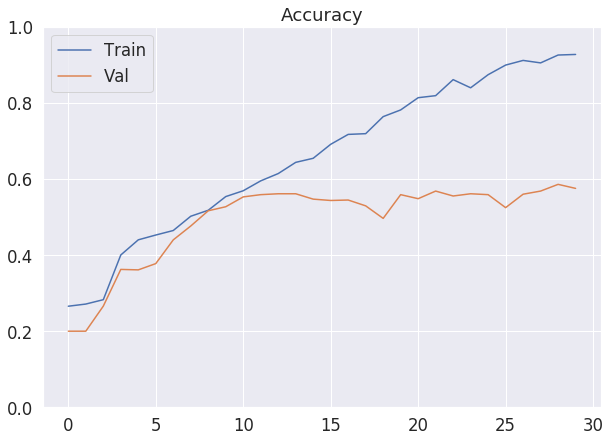

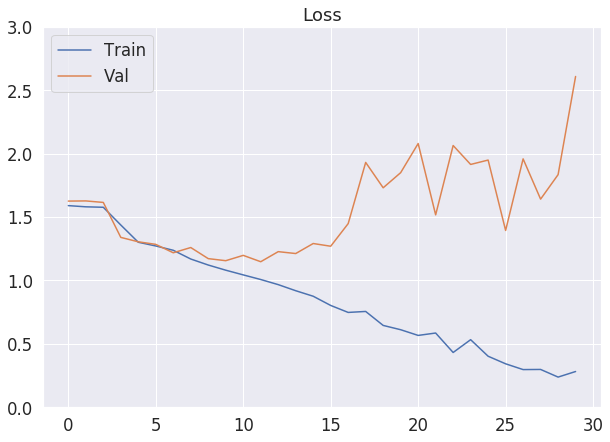

In [10]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Accuracy')
plt.ylim((0.0, 1.0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'], loc='upper left')

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0.0, 3.0))
plt.legend(['Train', 'Val'], loc='upper left')

### Evaluate the trained model with the test set.

In [ ]:
num_batches_per_epoch_test = int(round(len(test_images) / float(batch_size)))

print('Evaluating trained model...')
result = model.evaluate_generator(generator=data_generator(test_images,
                                                               test_labels_one_hot,
                                                               batch_size,
                                                               dataset_path, width, height),
                                      steps=num_batches_per_epoch_test)

print("Finished model.evaluate_generator")
print(model.metrics_names)
print(result)

### Generate the classification report from the test set.

85/85 [==============================] - 7s 80ms/step
              precision    recall  f1-score   support

       daisy       0.64      0.63      0.64       170
   dandelion       0.59      0.68      0.63       170
        rose       0.45      0.40      0.42       170
   sunflower       0.72      0.69      0.71       170
       tulip       0.54      0.55      0.55       170

    accuracy                           0.59       850
   macro avg       0.59      0.59      0.59       850
weighted avg       0.59      0.59      0.59       850



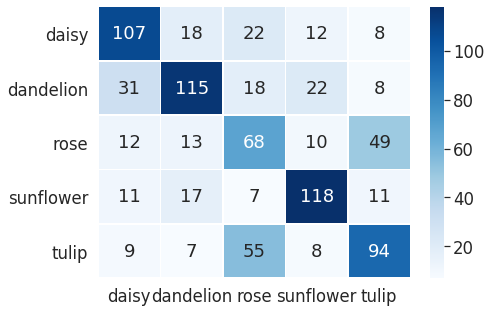

In [12]:
y_test_pred = model.predict_generator(generator=data_generator(test_images,
                                                                        test_labels_one_hot,
                                                                        batch_size,
                                                                        dataset_path, width, height),
                                          steps=num_batches_per_epoch_test,
                                          verbose=1)

y_test_pred_processed = np.argmax(y_test_pred, axis=-1)
y_test_processed = np.argmax(test_labels_one_hot, axis=-1)
classes_names = classes_dict.values()

print(classification_report(y_test_processed, y_test_pred_processed, target_names=classes_names))

cm = confusion_matrix(y_test_pred_processed, y_test_processed)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', linewidths=.8,
            yticklabels=classes_names, xticklabels=classes_names, cmap='Blues')

plt.show()

## 2 - Training the VGG16 model with regularization

### Define and compile the model architecture

In [13]:
base_vgg = vgg16.VGG16(include_top=False, weights=None, input_shape=input_shape)

x = base_vgg.output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dropout(0.3)(x)
x = Dense(len(classes_dict.keys()), activation='softmax', name='predictions')(x)

model = Model(inputs=base_vgg.input, outputs=x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model = load_model('trained_models/2_vgg16_model2.h5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
model.compile(optimizer=optimizers.SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


### Train the model.

In [ ]:
num_epochs = 30

print('Start training...')
history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=num_epochs,
                                  verbose=verbose,
                                  validation_data=val_gen,
                                  validation_steps=num_batches_per_epoch_val)
print('Model trained.')

In [16]:
model.save('2_vgg16_model2.h5')
print('Model saved.')

Model saved.


### Plot training metrics 

Plot accuracy and loss for the training and validation sets.

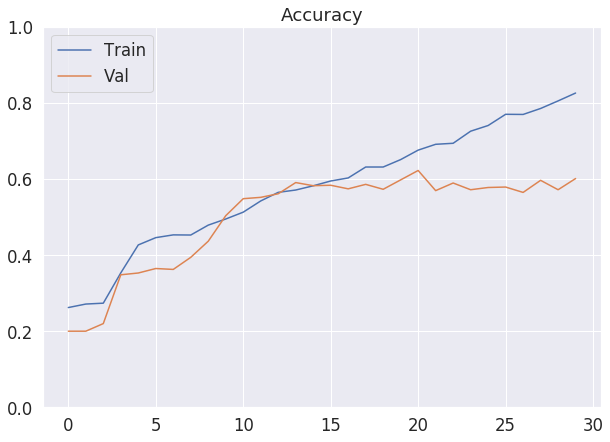

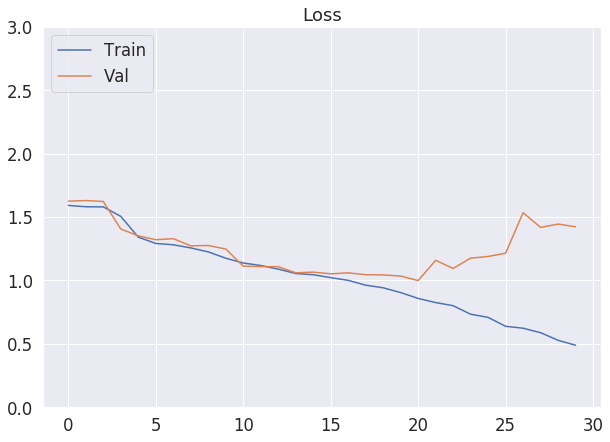

In [17]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Accuracy')
plt.ylim((0.0, 1.0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'], loc='upper left')

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0.0, 3.0))
plt.legend(['Train', 'Val'], loc='upper left')

### Evaluate the trained model with the test set.

In [ ]:
num_batches_per_epoch_test = int(round(len(test_images) / float(batch_size)))

print('Evaluating trained model...')
result = model.evaluate_generator(generator=data_generator(test_images,
                                                               test_labels_one_hot,
                                                               batch_size,
                                                               dataset_path, width, height),
                                      steps=num_batches_per_epoch_test)

print("Finished model.evaluate_generator")
print(model.metrics_names)
print(result)

### Generate the classification report from the test set.

85/85 [==============================] - 7s 79ms/step
              precision    recall  f1-score   support

       daisy       0.68      0.55      0.61       170
   dandelion       0.51      0.79      0.62       170
        rose       0.49      0.51      0.50       170
   sunflower       0.77      0.50      0.61       170
       tulip       0.56      0.55      0.56       170

    accuracy                           0.58       850
   macro avg       0.60      0.58      0.58       850
weighted avg       0.60      0.58      0.58       850



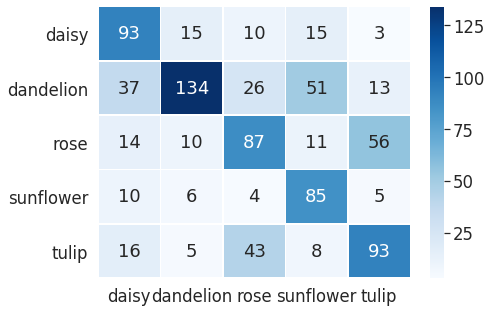

In [19]:
y_test_pred = model.predict_generator(generator=data_generator(test_images,
                                                                        test_labels_one_hot,
                                                                        batch_size,
                                                                        dataset_path, width, height),
                                          steps=num_batches_per_epoch_test,
                                          verbose=1)

y_test_pred_processed = np.argmax(y_test_pred, axis=-1)
y_test_processed = np.argmax(test_labels_one_hot, axis=-1)
classes_names = classes_dict.values()

print(classification_report(y_test_processed, y_test_pred_processed, target_names=classes_names))

cm = confusion_matrix(y_test_pred_processed, y_test_processed)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', linewidths=.8,
            yticklabels=classes_names, xticklabels=classes_names, cmap='Blues')

plt.show()

## 3 - Training with regularization + augmentation

### Create augmentation generator

Here we use the ImageDataGenerator from Keras to apply different types of augmentation.

In [20]:
image_gen = ImageDataGenerator(zoom_range=0.3,
                               rotation_range=30,
                               horizontal_flip=True,
                               fill_mode='reflect')

In [21]:
def augmentation_generator(in_generator):

    for in_x, in_y in in_generator:
        g_x = image_gen.flow(in_x, in_y,
                             batch_size=in_x.shape[0])
        x, y = next(g_x)

        yield x, y

In [22]:
train_gen = augmentation_generator(train_gen)
val_gen = augmentation_generator(val_gen)

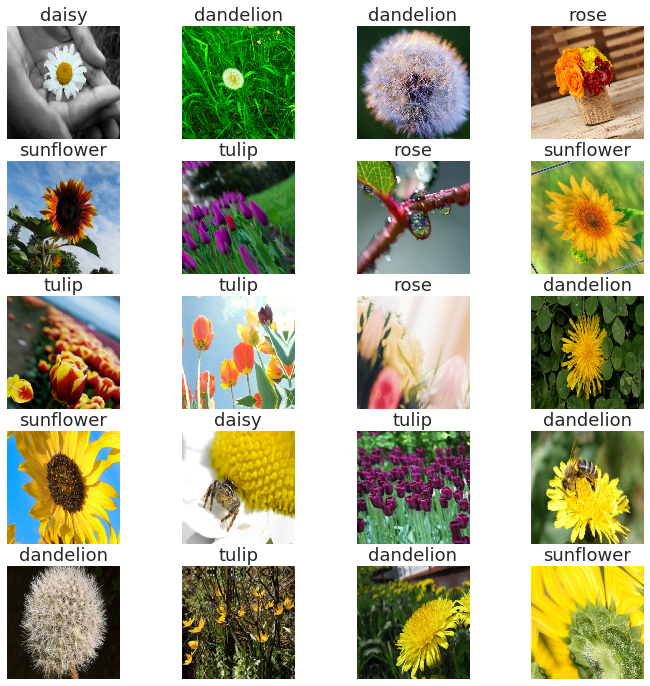

In [23]:
w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1,21):
  sample = next(train_gen)
  img = cv2.cvtColor((sample[0][0]+1)/2, cv2.COLOR_BGR2RGB)
  label = classes_dict[np.argmax(sample[1][0], axis=-1)]
  fig.add_subplot(rows, columns, i)
  plt.title(label)
  plt.axis('off')
  plt.imshow(img)
plt.show()

### Define and compile the model architecture

In [24]:
base_vgg = vgg16.VGG16(include_top=False, weights=None, input_shape=input_shape)

x = base_vgg.output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dropout(0.3)(x)
x = Dense(len(classes_dict.keys()), activation='softmax', name='predictions')(x)

model = Model(inputs=base_vgg.input, outputs=x)

In [17]:
model = load_model('trained_models/2_vgg16_model3.h5')

In [25]:
model.compile(optimizer=optimizers.SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model.

In [ ]:
num_epochs = 30

print('Start training...')
history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=num_epochs,
                                  verbose=verbose,
                                  validation_data=val_gen,
                                  validation_steps=num_batches_per_epoch_val)
print('Model trained.')

model.save('2_vgg16_model3_150epochs.h5')
print('Model saved.')

### Plot training metrics 

Plot accuracy and loss for the training and validation sets.

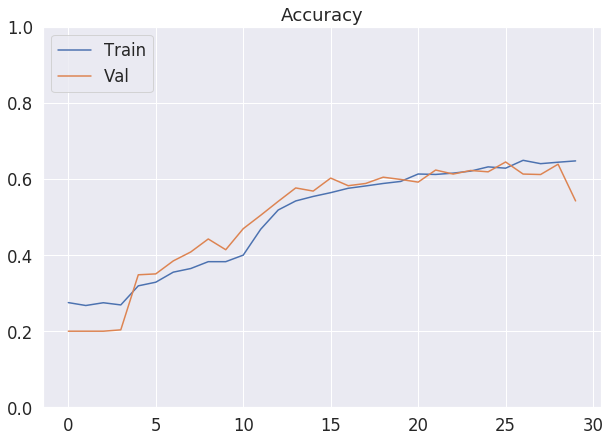

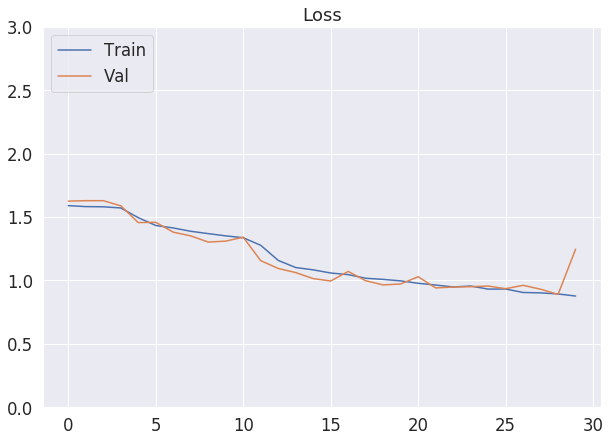

In [27]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Accuracy')
plt.ylim((0.0, 1.0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'], loc='upper left')

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0.0, 3.0))
plt.legend(['Train', 'Val'], loc='upper left')

### Evaluate the trained model with the test set.

In [ ]:
num_batches_per_epoch_test = int(round(len(test_images) / float(batch_size)))

print('Evaluating trained model...')
result = model.evaluate_generator(generator=data_generator(test_images,
                                                               test_labels_one_hot,
                                                               batch_size,
                                                               dataset_path, width, height),
                                      steps=num_batches_per_epoch_test)

print("Finished model.evaluate_generator")
print(model.metrics_names)
print(result)

### Generate the classification report from the test set.

85/85 [==============================] - 7s 82ms/step
              precision    recall  f1-score   support

       daisy       0.85      0.34      0.49       170
   dandelion       0.37      0.94      0.54       170
        rose       0.62      0.29      0.40       170
   sunflower       0.56      0.39      0.46       170
       tulip       0.59      0.55      0.57       170

    accuracy                           0.50       850
   macro avg       0.60      0.50      0.49       850
weighted avg       0.60      0.50      0.49       850



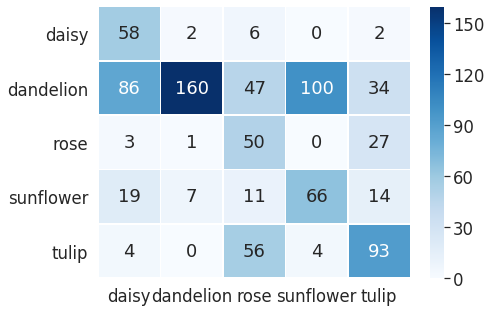

In [29]:
y_test_pred = model.predict_generator(generator=data_generator(test_images,
                                                                        test_labels_one_hot,
                                                                        batch_size,
                                                                        dataset_path, width, height),
                                          steps=num_batches_per_epoch_test,
                                          verbose=1)

y_test_pred_processed = np.argmax(y_test_pred, axis=-1)
y_test_processed = np.argmax(test_labels_one_hot, axis=-1)
classes_names = classes_dict.values()

print(classification_report(y_test_processed, y_test_pred_processed, target_names=classes_names))

cm = confusion_matrix(y_test_pred_processed, y_test_processed)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', linewidths=.8,
            yticklabels=classes_names, xticklabels=classes_names, cmap='Blues')

plt.show()